<a href="https://colab.research.google.com/github/Ashu156/Neural-time-series-analysis-LFP/blob/main/wavelet_spectral_power.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import data file from local machine
from google.colab import files
uploaded = files.upload()

Saving sampleEEGdata.mat to sampleEEGdata.mat


In [2]:
import numpy as np
import scipy.io
from matplotlib import pyplot as plt

from numpy import pi, sin, cos, exp, sqrt, log, log10, random, angle  #import basic functions from numpy that we'll need
from numpy.fft import fft, ifft

In [3]:
data = scipy.io.loadmat('sampleEEGdata.mat')
EEGdata = data["EEG"][0,0]["data"]
EEGpnts = data["EEG"][0,0]["pnts"][0,0] #number of points in EEG data
EEGtimes = data["EEG"][0,0]["times"][0]
EEGsrate = float(data["EEG"][0,0]["srate"][0]) #make float for division purposes later
EEGtrials = data["EEG"][0,0]["trials"][0,0]

EEGchanlocslabels=data["EEG"][0,0]["chanlocs"][0]["labels"]

In [4]:
def nextpow2(i):
    n = 1
    while n < i: n *= 2
    return n

In [5]:
#definitions, selections...

chan2use = "FCz"
min_freq = 2
max_freq = 80
num_frex = 80

#define wavelet parameters
time = np.arange(-1,1+1/EEGsrate,1/EEGsrate)
frex = np.logspace(log10(min_freq),log10(max_freq),num_frex)
s    = np.logspace(log10(3),log10(10),num_frex)/(2*pi*frex)

#use the following lines to reproduce figure 13.14
# s =  3./(2*pi*frex)
# s = 10./(2*pi*frex)

# define convolution parameters
n_wavelet = len(time)
n_data = EEGpnts*EEGtrials
n_convolution = n_wavelet + n_data - 1
n_conv_pow2 = nextpow2(n_convolution)
half_of_wavelet_size = (n_wavelet)//2

selectedChannel =  EEGchanlocslabels  == chan2use #specify index (channel number) of label 

#get FFT of data
eegfft = fft(np.reshape(EEGdata[selectedChannel,:,:],[EEGpnts*EEGtrials],order="F"),n_conv_pow2)

# MATLAB: baseidx = dsearachn(EEGtimes)#
#python has no dsearchn() function, but since this is only a 1-D array, we can make a simple one ourselves

def closest(X, p):
    disp = X - p
    return np.argmin((disp*disp))


baseidx = [closest(EEGtimes,x) for x in [-500,-200]]

#initialize
eegpower = np.zeros([num_frex,EEGpnts]) #frequencies x time x trials
for fi in range(num_frex):
    
    #take the fft of the wavelet
    wavelet = fft(np.sqrt(1/(s[fi]*np.sqrt(pi))) * exp(2*1j*pi*frex[fi]*time) * exp(-time**2/(2*(s[fi]**2))),n_conv_pow2)

    #convolution 
    eegconv = ifft(wavelet*eegfft) #convolution theorem
    eegconv = eegconv[:n_convolution]
    eegconv = eegconv[half_of_wavelet_size:-half_of_wavelet_size]
    
    #average power over trials
    #this performs baseline transform, which is covered in more depth in ch18
    
    temppower = np.mean(np.absolute(np.reshape(eegconv,[EEGpnts,EEGtrials],order="F"))**2,axis=1)
    eegpower[fi,:] = 10*log10(temppower/np.mean(temppower[baseidx[0]:baseidx[1]]))
    
    


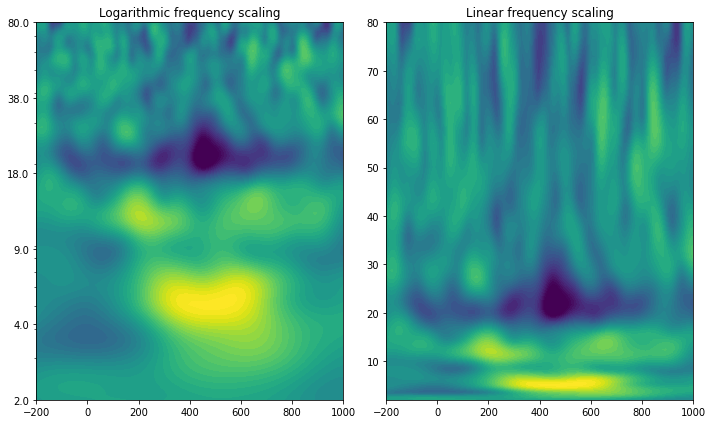

In [7]:
plt.figure(figsize=[10,6])
ax1=plt.subplot(121)
ax1.set_yscale("log")
    
CS = plt.contourf(EEGtimes,frex, eegpower, 80,
                vmin=-3,vmax=3,
                cmap=plt.cm.viridis,
                origin = "lower",
                )
ax1.set_yticks(np.logspace(log10(min_freq),log10(max_freq),6))
ax1.set_yticklabels(np.round(np.logspace(log10(min_freq),log10(max_freq),6)))
ax1.set_xlim([-200,1000])
plt.title("Logarithmic frequency scaling")


ax2=plt.subplot(122)
CS = plt.contourf(EEGtimes,frex, eegpower, 80,
                vmin=-3,vmax=3,
                cmap=plt.cm.viridis,
#                 origin = ,
                )
ax2.set_xlim([-200,1000])
plt.title("Linear frequency scaling")

plt.tight_layout()

In [1]:
# EXAMPLE 2

# Import data file from local machine
from google.colab import files
uploaded = files.upload()

Saving fear_recall.mat to fear_recall (1).mat


In [2]:
import numpy as np
import scipy.io
from matplotlib import pyplot as plt

from numpy import pi, sin, cos, exp, sqrt, log, log10, random, angle  #import basic functions from numpy that we'll need
from numpy.fft import fft, ifft

In [3]:
data = scipy.io.loadmat('fear_recall.mat')
raw_data = data['CSC28_DP']
raw_times = data['CSC28_TS']
raw_events = data['Events_PIPS'] / 1000000.

In [4]:
raw_info = data['CSC28_NlxHeader']
ADBitVolts = float(raw_info[14][0][0][12:37])
sfreq = int(float(raw_info[13][0][0][-17:-1]))
print(ADBitVolts, sfreq)

3.0518510385491e-08 1017


In [5]:
import scipy.signal
dp_csc = raw_data * ADBitVolts
n_trials = raw_events.shape[1]
ts_csc = raw_times / 1000000.
dp_csc = dp_csc.flatten()
dp_csc = scipy.signal.detrend(dp_csc, axis = -1, type = 'constant')

In [6]:
tts_csc = np.linspace(ts_csc[0, 0], ts_csc[0, -1], len(dp_csc))

In [7]:
def closest(X, p):
    disp = X - p
    return np.argmin((disp*disp))
ind = []
for i in range(n_trials):
  idx = closest(tts_csc, raw_events[0,i])
  ind.append(idx)

In [27]:
lfp = []
increment = int(sfreq)
for k in range (n_trials):
  start_idx = ind[k]
  signal = dp_csc[start_idx - increment: start_idx + increment]
  lfp.append(signal)
lfp = np.array(lfp)

In [28]:
def nextpow2(i):
    n = 1
    while n < i: n *= 2
    return n

In [66]:
#definitions, selections...
min_freq = 1
max_freq = 150
num_frex = 150

#define wavelet parameters
time = np.arange(-1,1+1/sfreq,1/sfreq)
frex = np.logspace(log10(min_freq),log10(max_freq),num_frex)
s    = np.logspace(log10(3),log10(7),num_frex)/(2*pi*frex)

#use the following lines to reproduce figure 13.14
# s =  3./(2*pi*frex)
# s = 10./(2*pi*frex)

# define convolution parameters
n_wavelet = len(time)
EEGpnts = lfp.shape[1]
EEGtrials = lfp.shape[0]
EEGtimes = np.arange(-1, 1, 1/sfreq)
n_data = EEGpnts*EEGtrials
n_convolution = n_wavelet + n_data - 1
n_conv_pow2 = nextpow2(n_convolution)
half_of_wavelet_size = (n_wavelet)//2

#get FFT of data
eegfft = fft(np.reshape(lfp,[EEGpnts*EEGtrials],order="F"),n_conv_pow2)

# MATLAB: baseidx = dsearachn(EEGtimes)#
#python has no dsearchn() function, but since this is only a 1-D array, we can make a simple one ourselves

def closest(X, p):
    disp = X - p
    return np.argmin((disp*disp))


baseidx = [closest(EEGtimes,x) for x in [-0.1,0.]]

#initialize
eegpower = np.zeros([num_frex,EEGpnts]) #frequencies x time x trials
for fi in range(num_frex):
    
    #take the fft of the wavelet
    wavelet = fft(np.sqrt(1/(s[fi]*np.sqrt(pi))) * exp(2*1j*pi*frex[fi]*time) * exp(-time**2/(2*(s[fi]**2))),n_conv_pow2)

    #convolution 
    eegconv = ifft(wavelet*eegfft) #convolution theorem
    eegconv = eegconv[:n_convolution]
    eegconv = eegconv[half_of_wavelet_size:-half_of_wavelet_size]
    
    #average power over trials
    #this performs baseline transform, which is covered in more depth in ch18
    
    temppower = np.mean(np.absolute(np.reshape(eegconv,[EEGpnts,EEGtrials],order="F"))**2,axis=1)
    eegpower[fi,:] = 10*log10(temppower/np.mean(temppower[baseidx[0]:baseidx[1]]))

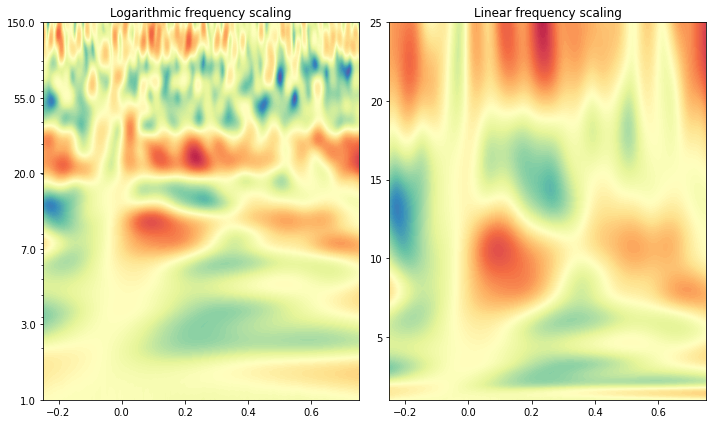

In [69]:
plt.figure(figsize=[10,6])
ax1=plt.subplot(121)
ax1.set_yscale("log")
    
CS = plt.contourf(EEGtimes,frex, eegpower, 120,
                #vmin=-3,vmax=3,
                cmap=plt.cm.Spectral_r,
                origin = "lower",
                )
ax1.set_yticks(np.logspace(log10(min_freq),log10(max_freq),6))
ax1.set_yticklabels(np.round(np.logspace(log10(min_freq),log10(max_freq),6)))
ax1.set_xlim([-0.25,0.75])
ax2.set_ylim([1.,25.])
plt.title("Logarithmic frequency scaling")


ax2=plt.subplot(122)
CS = plt.contourf(EEGtimes,frex, eegpower, 120,
                #vmin=-3,vmax=3,
                cmap=plt.cm.Spectral_r,
                 origin = "lower"
                )
ax2.set_xlim([-0.25,0.75])
ax2.set_ylim([1.,25.])
plt.title("Linear frequency scaling")

plt.tight_layout()